# Simple Spread
**Objectives**: The environment has N agents and N landmarks. Agents must learn to cover all the landmarks while avoiding collisions. All agents are globally rewarded based on how far the closest agents is to each landmark (sum of the minimum distances). The agents are penalised if they collide with other agents (-1 for each collision).

**Actions**:
 - Agent observations: `[self_vel, self_pos, landmark_rel_positions, other_agent_rel_positions, communication]`
 - Agent action space: `[no_action, move_left, move_right, move_down, move_up]`

In [71]:
from pettingzoo.mpe import simple_spread_v3
num_agents = 3
env = simple_spread_v3.env(
    N=num_agents,
    max_cycles=25,
    local_ratio=0.5,
    continuous_actions=False,
    render_mode="rgb_array"
)

In [72]:
env.reset()
env.agents

['agent_0', 'agent_1', 'agent_2']

In [73]:
for agent in env.agents:
    print(agent, env.observation_space(agent))

agent_0 Box(-inf, inf, (18,), float32)
agent_1 Box(-inf, inf, (18,), float32)
agent_2 Box(-inf, inf, (18,), float32)


In [74]:
for agent in env.agents:
    print(agent, env.action_space(agent))

agent_0 Discrete(5)
agent_1 Discrete(5)
agent_2 Discrete(5)


In [75]:
env = simple_spread_v3.parallel_env(
    N=num_agents,
    max_cycles=25,
    local_ratio=0.5,
    continuous_actions=True,
    render_mode=None
)

In [76]:
env.reset()

({'agent_0': array([ 0.        ,  0.        , -0.49659082,  0.19935773,  1.4552721 ,
          0.21039093, -0.20550542,  0.11756655,  0.05244255,  0.35620427,
         -0.05508013, -0.40189353,  0.48561892, -0.5094123 ,  0.        ,
          0.        ,  0.        ,  0.        ], dtype=float32),
  'agent_1': array([ 0.        ,  0.        , -0.55167097, -0.20253578,  1.5103523 ,
          0.6122844 , -0.15042529,  0.5194601 ,  0.10752268,  0.75809777,
          0.05508013,  0.40189353,  0.54069906, -0.10751877,  0.        ,
          0.        ,  0.        ,  0.        ], dtype=float32),
  'agent_2': array([ 0.        ,  0.        , -0.01097191, -0.31005454,  0.96965325,
          0.7198032 , -0.6911243 ,  0.6269788 , -0.43317637,  0.86561656,
         -0.48561892,  0.5094123 , -0.54069906,  0.10751877,  0.        ,
          0.        ,  0.        ,  0.        ], dtype=float32)},
 {'agent_0': {}, 'agent_1': {}, 'agent_2': {}})

In [77]:
env.agents
actions_dict = {agent: env.action_space(agent).sample() for agent in env.agents}
actions_dict

{'agent_0': array([0.05733168, 0.46264973, 0.07368609, 0.1554525 , 0.33114856],
       dtype=float32),
 'agent_1': array([0.9906404 , 0.9407897 , 0.89461094, 0.07858131, 0.34973288],
       dtype=float32),
 'agent_2': array([0.16457124, 0.35037655, 0.998845  , 0.6019372 , 0.5196411 ],
       dtype=float32)}

In [78]:
observations, rewards, term, trunc, info = env.step(actions_dict)
rewards

defaultdict(int,
            {'agent_0': -0.9022106151973255,
             'agent_1': -0.9022106151973255,
             'agent_2': -0.9022106151973255})

In [79]:
import supersuit as ss
env = ss.pettingzoo_env_to_vec_env_v1(env)
observations = env.reset()[0]
print(type(observations), observations.shape)

<class 'numpy.ndarray'> (3, 18)


In [80]:
env.num_envs

3

In [81]:
from stable_baselines3 import DDPG
model = DDPG("MlpPolicy", env, verbose=3, learning_rate=1e-3, batch_size=256, gamma=0.95, train_freq=256*25, 
             policy_kwargs={"net_arch": [128, 128]})

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [82]:
import torch as th
import numpy as np
def policy(observation, agent, action_space):
    with th.no_grad():
        action = model.policy(th.tensor(observation[None, :]), deterministic=True)
    action = action.numpy()[0]
    return np.clip(action, action_space.low, action_space.high)

In [83]:
eval_env = simple_spread_v3.env(
    N=num_agents,
    max_cycles=25,
    local_ratio=0.5,
    continuous_actions=True,
    render_mode="rgb_array"
)

seed = 1

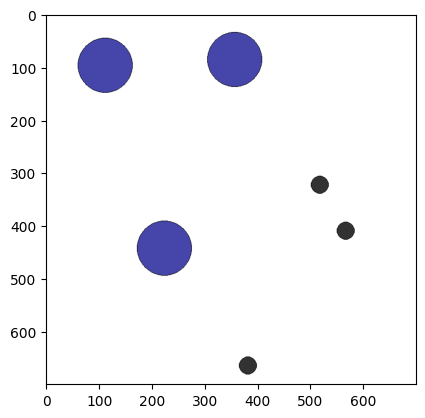

-35.11841194162657


In [84]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
fig, ax = plt.subplots(figsize=(5, 5))
ep_rewards = []
num_episodes = 1
for ep in range(num_episodes):
    eval_env.reset(seed=seed)
    total_reward = {agent: 0 for agent in eval_env.agents}
    for agent in eval_env.agent_iter():
        observation, reward, termination, trunc, info = eval_env.last()
        total_reward[agent] += reward
        if (termination or trunc):
            ep_rewards.append(total_reward[agent])
            action = None
        else:
            action = policy(observation, agent, env.action_space)
        eval_env.step(action)
        img = eval_env.render()
        plt.imshow(img)
        clear_output(wait=True)
        plt.pause(0.1)

print(np.mean(ep_rewards))